<h1> PyTorch Classification with MLP </h1>
Lets see how we can train our first neural network using the Pytorch funcunalities we have previously seen! In this notebook we will be training a Multilayer Perceptron (MLP) with the MNIST dataset. We will see how to use Pytorch inbuilt datasets, how to construct a MLP using the Pytorch nn.module class and how to construct a training and testing loop to perform stochastic gradient descent (SGD).

<img src="../data/MNIST.gif" width="700" align="center">

Animation of MNIST digits and a MLP's activations changing via learning

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torchvision import transforms
from torchvision.datasets import MNIST
import torchvision

from tqdm.notebook import trange, tqdm
import numpy as np
import matplotlib.pyplot as plt
import time

<h2> Classification </h2>
In this Notebook we are performing "classification", that is we want our model to predict what group a given input belongs to after being trained with a large number of examples. In our case we are using MNIST, a data-set of small black and white hand written digits. We want our model to predict what digit (0-9) is in the image!

[Classification Explained](https://www.datacamp.com/blog/classification-machine-learning)

<h2> Download the MNIST Train and Test set </h2>
The MNIST dataset is a large database of handwritten digits that is commonly used for training and testing in the field of machine learning, it consists of 60,000 training images and 10,000 testing images as well as the corresponding digit class (0-9) (it has moved out of fashion these days because it is "too easy" to learn though it is still used at times as a "proof of concept").  <br>
Pytorch has constructed a number of <a href="https://pytorch.org/vision/0.15/datasets.html">dataset classes</a> that will automatically download various datasets making it very easy for us to train our models.

In [2]:
batch_size = 256
data_set_root = "../../datasets"

# Create a train and test dataset using the Pytorch MNIST dataloader class
train = MNIST(data_set_root, train=True,  download=True, transform=transforms.ToTensor())
test  = MNIST(data_set_root, train=False, download=True, transform=transforms.ToTensor())

# Using the Pytorch dataloader class and the Pytorch datasets we with create itterable dataloader objects
train_loader = dataloader.DataLoader(train, shuffle=True, batch_size=batch_size, num_workers=0, pin_memory=False) 
test_loader = dataloader.DataLoader(test, shuffle=False, batch_size=batch_size, num_workers=0, pin_memory=False)

# NOTE:num_workers is the number of extra threads the dataloader will spawn to load the data from file, 
# you will rarely need more than 4 
# NOTE!!! ON WINDOWS THERE CAN BE ISSUES WITH HAVING MORE THAN 0 WORKERS!! IF YOUR TRAINING LOOP STALLS AND DOES
# NOTHING SET num_workers TO 0!

# NOTE:pin_memory is only useful if you are training with a GPU!!!! If it is True then the GPU will pre-allocate
# memory for the NEXT batch so the CPU-GPU transfer can be handled by the DMA controller freeing up the CPU

In [3]:
# Set device to GPU_indx if GPU is avaliable
# GPU index is set by the NVIDIA Drivers if you have only one GPU then it should always be 0
GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else 'cpu')

<h3> Visualize a few training samples </h3>
Lets visualise that mini-batches that the dataloader gives us

In [4]:
# We can create an itterater using the dataloaders and take a random sample 
images, labels = next(iter(train_loader))
print("The input data shape is :\n", images.shape)
print("The target output data shape is :\n", labels.shape)

The input data shape is :
 torch.Size([256, 1, 28, 28])
The target output data shape is :
 torch.Size([256])


We can see that (as specified) our mini-batch is 256. The dataloader has passed us a 4D Tensor as input data, the first dimension (d0) is known as the "batch dimension" (B) the other three are the image dimensions (CxHxW). We can this of this 4D Tensor as a stack of 256, 1 channel, 28x28 images.<br>
The image labels are a 1D Tensor, 1 single scalar value per image (per mini-batch "instance").

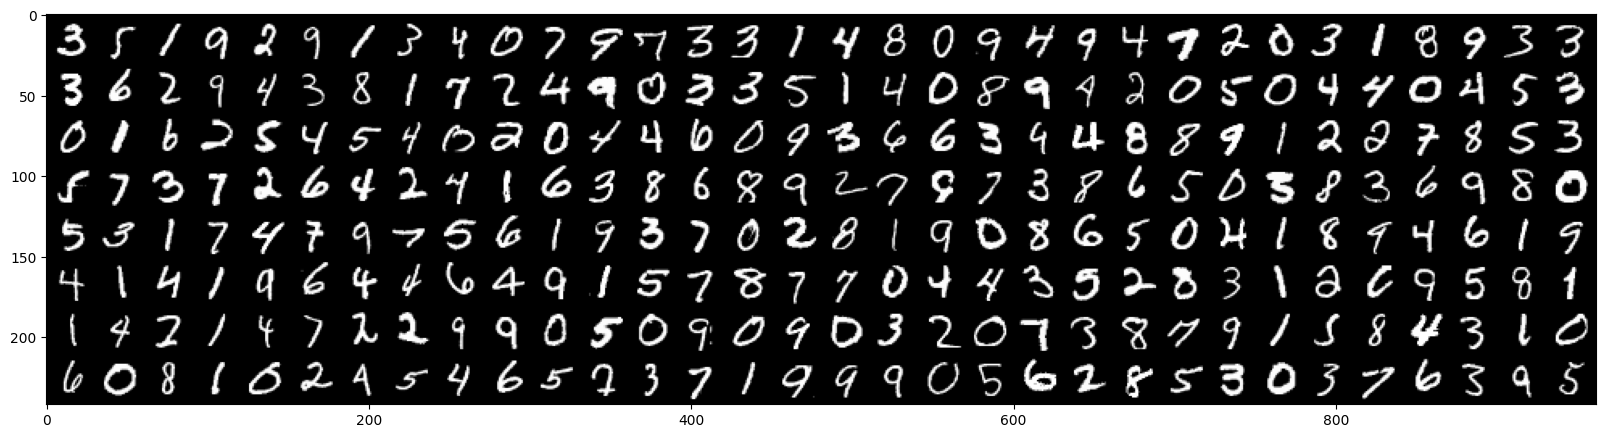

In [5]:
# Lets visualise an entire batch of images!
plt.figure(figsize = (20, 10))
out = torchvision.utils.make_grid(images, 32)
plt.imshow(out.numpy().transpose((1, 2, 0)))

## Define our Neural Network Model 
We define our model using the torch.nn.Module class

In [6]:
# Lets create a simple MLP network similar to the sine wave approximator
class Simple_MLP(nn.Module):
    def __init__(self, num_classes):
        super(Simple_MLP, self).__init__()
        # We will use 4 linear layers
        # The input to the model is 784 (28x28 - the image size)
        # and the should be num_classes outputs
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, num_classes)

    def forward(self, x):
        # The data we pass the model is a batch of single channel images
        # with shape BSx1x28x28 we need to flatten it to BSx784
        # To use it in a linear layer
        x = x.reshape(x.shape[0], -1)
        
        # We will use a relu activation function for this network! (F.relu)
        # NOTE F.relu is the "functional" version of the activation function!
        # nn.ReLU is a class constructor of a "ReLU" object
        # These two things are the same for MOST purposes!
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

<h3> Create the model and define the Loss and Optimizer</h3>
Since this is a classification task, we will use Cross Entropy Loss. We define our criterion using Cross Entropy Loss 

[torch.nn.CrossEntropyLoss](https://pytorch.org/docs/master/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss)

[Killer Combo: Softmax and Cross Entropy by Paolo Perrotta
](https://levelup.gitconnected.com/killer-combo-softmax-and-cross-entropy-5907442f60ba)

Just like in the sine wave approximation, experiment with different optimizers and hyperparameters 

In [7]:
# Create our model
model = Simple_MLP(10).to(device)
# Create our loss function
criterion = nn.CrossEntropyLoss()
# Define our loss funcition and optimizer
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)

# Number of Epochs
n_epochs = 20

# We can print out our model structure
print(model)
# Note: this is only the order in which the layers were defined NOT the path of the forward pass!

Simple_MLP(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
)


<h3> Create a function that will train the network for one epoch </h3>

In [8]:
def train_epoch(model, train_loader, criterion, optimizer, loss_logger):
    for batch_idx, (data, target) in enumerate(tqdm(train_loader, desc="Training", leave=False)):   
        outputs = model(data.to(device))
        loss = criterion(outputs, target.to(device))
        
        optimizer.zero_grad()   
        loss.backward()
        optimizer.step()
        
        loss_logger.append(loss.item())

    return model, optimizer, loss_logger

<h3> Create a function that will evaluate our network's performance on the test set </h3>

In [9]:
def test_model(model, test_loader, criterion, loss_logger):
    
    # With no_grad we don't need pytorch to track our operations here
    # We can speed up our evaluation by turning auto grad off
    with torch.no_grad():
        correct_predictions = 0
        total_predictions = 0
        for batch_idx, (data, target) in enumerate(tqdm(test_loader, desc="Testing", leave=False)):   
            outputs = model(data.to(device))
            
            # Calculate the accuracy of the model
            # you'll need to accumulate the accuracy over multiple steps
            
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == target.to(device)).sum().item()
            total_predictions += target.shape[0]
            
            # Calculate the loss
            loss = criterion(outputs, target.to(device))
            loss_logger.append(loss.item())
            
        acc = (correct_predictions/total_predictions) * 100.0
        return loss_logger, acc

## Train the model for N epochs
We call our training and testing functions in a loop, while keeping track of the losses and accuracy. 

In [10]:
train_loss = []
test_loss  = []
test_acc   = []

In [11]:
for i in trange(n_epochs, desc="Epoch", leave=False):
    model, optimizer, train_loss = train_epoch(model, train_loader, criterion, optimizer, train_loss)
    test_loss, acc = test_model(model, test_loader, criterion, test_loss)
    test_acc.append(acc)
    
print("Final Accuracy: %.2f%%" % acc)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Final Accuracy: 98.25%


In [12]:
x = model(images.to(device))

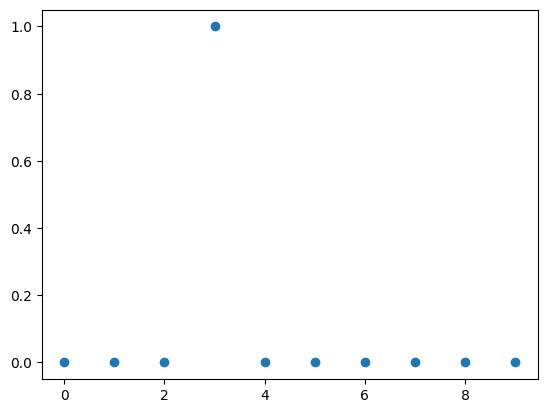

In [13]:
plt.scatter(np.arange(10), F.softmax(x, 1)[0].detach().cpu().numpy())

## Visualize Training Data

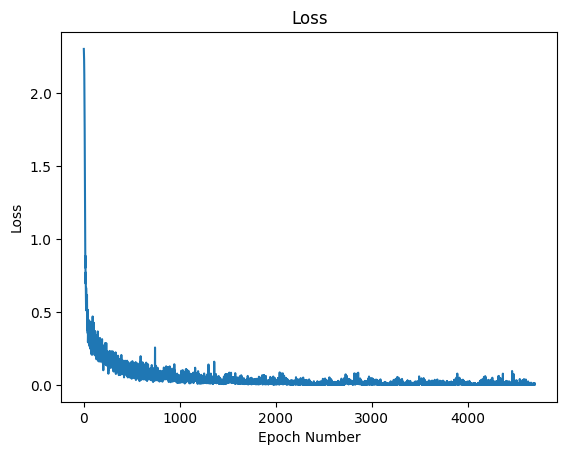

In [14]:
plt.title('Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(train_loss)

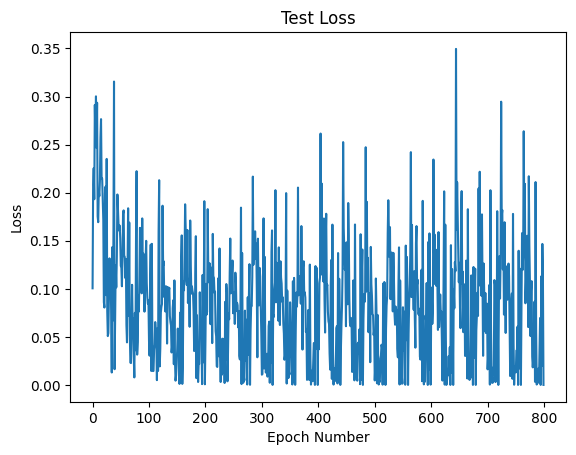

In [15]:
plt.title('Test Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(test_loss)

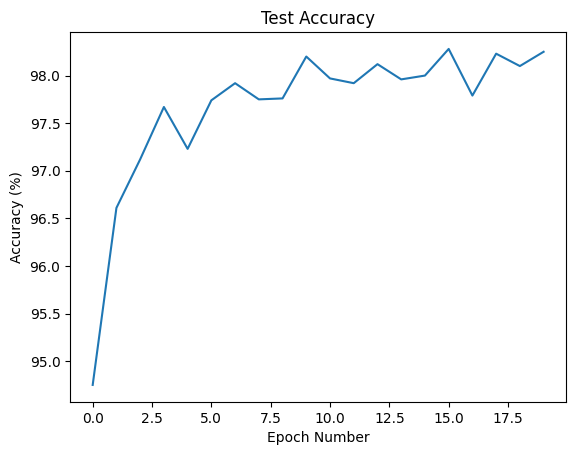

In [16]:
plt.title('Test Accuracy')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy (%)')
plt.plot(test_acc)